In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

batch_size = 10**3
Z_dim = 3
# Extended MNIST Dataset
train_dataset = datasets.EMNIST(root='./emnist_data/', split= 'byclass', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.EMNIST(root='./emnist_data/', split= 'byclass', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=Z_dim)
if torch.cuda.is_available():
    vae.cuda()
    model = vae.to('cuda')
    print('cuda')

cuda


In [3]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=3, bias=True)
  (fc32): Linear(in_features=256, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [4]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [5]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [6]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [7]:
num_epochs = 500
for epoch in range(0, num_epochs):
    train(epoch)
    test()

Train Epoch: 0 [0/697932 (0%)]	Loss: 545.326500
Train Epoch: 0 [100000/697932 (14%)]	Loss: 243.339359
Train Epoch: 0 [200000/697932 (29%)]	Loss: 222.329859
Train Epoch: 0 [300000/697932 (43%)]	Loss: 216.709953
Train Epoch: 0 [400000/697932 (57%)]	Loss: 214.012734
Train Epoch: 0 [500000/697932 (72%)]	Loss: 206.931172
Train Epoch: 0 [600000/697932 (86%)]	Loss: 202.480047
====> Epoch: 0 Average loss: 223.5106
====> Test set loss: 204.5342
Train Epoch: 1 [0/697932 (0%)]	Loss: 203.609000
Train Epoch: 1 [100000/697932 (14%)]	Loss: 204.191641
Train Epoch: 1 [200000/697932 (29%)]	Loss: 200.528469
Train Epoch: 1 [300000/697932 (43%)]	Loss: 201.959656
Train Epoch: 1 [400000/697932 (57%)]	Loss: 196.306719
Train Epoch: 1 [500000/697932 (72%)]	Loss: 201.166438
Train Epoch: 1 [600000/697932 (86%)]	Loss: 202.148781
====> Epoch: 1 Average loss: 200.6304
====> Test set loss: 197.3325
Train Epoch: 2 [0/697932 (0%)]	Loss: 197.475719
Train Epoch: 2 [100000/697932 (14%)]	Loss: 195.622391
Train Epoch: 2 [20

In [105]:
with torch.no_grad():

    #Make many examples of latent space stuff
    for i in range(10):
        z = torch.randn( 64, Z_dim).cuda()
        sample = vae.decoder(z).cuda()

        save_image(sample.view(64, 1, 28, 28), './samples/sample_' +str(i) +'.png')

In [8]:
torch.save(vae,'./trained_models/latest_model_500_epochs_ltsp_3.pt')

In [170]:
val = 79
num_examples = 10
for x in range(num_examples):
    test_image_A, test_target_A = test_dataset[val + x]
    #(test_image_A.view(1,1,28,28))
    print(x, test_target_A)
    #save_image(test_image_A.view(1, 1, 28, 28), './examples/example_input_'+str(val)+',' +str(x)+'.png')

    #Shape input into what the network wants
    z = torch.flatten(test_image_A)#.cuda()
    z = torch.tensor(z)
    z = z.cuda()

    #Map through the model to the latent space and the whole way through
    latent_sample =  vae.encoder(z)[0]
    sample = vae.forward(z)[0].cuda()
    direct_sample = vae.decoder(latent_sample)#[0]

    #save_image(sample.view(1, 1, 28, 28), './examples/example_decoded_'+str(val)+',' +str(x)+'.png')

    comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
    save_image(comb_tensor.view(3, 1, 28, 28), './examples/example_endecoded_'+str(val)+',' +str(x)+'.png')



0 40
1 32
2 4
3 8
4 2
5 1
6 6
7 39
8 9
9 5


/tmp/ipykernel_66026/813719249.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [10]:
#Capital A label is 10
#lower case a label is 36
val = 0
test_target_A  =1
while test_target_A != 36:
    test_image_A, test_target_A = test_dataset[val]
    val += 1
    if val%100 == 0:
        print(val)


print(x, test_target_A)
#save_image(test_image_A.view(1, 1, 28, 28), './examples/example_input_'+str(val)+',' +str(x)+'.png')

#Shape input into what the network wants
z = torch.flatten(test_image_A)#.cuda()
z = torch.tensor(z)
z = z.cuda()

#Map through the model to the latent space and the whole way through
latent_sample =  vae.encoder(z)[0]
sample = vae.forward(z)[0].cuda()
direct_sample = vae.decoder(latent_sample)#[0]

#save_image(sample.view(1, 1, 28, 28), './examples/example_decoded_'+str(val)+',' +str(x)+'.png')

comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
save_image(comb_tensor.view(3, 1, 28, 28), './examples/example_ltsp_3_endecoded_'+str(val)+',' +str(x)+'.png')


NameError: name 'x' is not defined

In [11]:
#Capital A label is 10
#lower case a label is 36
def all_test_images_indexes_for_label(target_label):
    indexes = []
    for index in range(len(test_dataset)): 
        image, label = test_dataset[index]
        if label == target_label:
            indexes.append(index)
    return indexes

def master_image_label_map():
    master_label = []
    for index in range(len(test_dataset)): 
        image, label = test_dataset[index]
        master_label.append(label)
    return master_label



In [14]:
Label_Map = master_image_label_map()
print(Label_Map[79:85])

[40, 32, 4, 8, 2, 1]


In [12]:
print( all_test_images_indexes_for_label(10))

[195, 303, 497, 738, 791, 798, 862, 880, 950, 1091, 1274, 1332, 1535, 1839, 1928, 1951, 2130, 2393, 2402, 3009, 3153, 3198, 3506, 3763, 4116, 4204, 4231, 4233, 4380, 4381, 4442, 4534, 4574, 4650, 4763, 5035, 5118, 5203, 5556, 5571, 5693, 5803, 5904, 5907, 6048, 6058, 6088, 6128, 6271, 6445, 6519, 6626, 6653, 6655, 6660, 6739, 6833, 6913, 7040, 7092, 7131, 7407, 7435, 7440, 7512, 7879, 7992, 8046, 8087, 8179, 8471, 8491, 8556, 8673, 8818, 8867, 8938, 9022, 9040, 9125, 9194, 9291, 9490, 9546, 9687, 9756, 9844, 9914, 9933, 9955, 10050, 10108, 10149, 10323, 10351, 10428, 10572, 10578, 10671, 10700, 10735, 11015, 11345, 11346, 11347, 11610, 11742, 11874, 11878, 12019, 12029, 12036, 12179, 12294, 12295, 12304, 12621, 12777, 13163, 13194, 13199, 13350, 13635, 13670, 13820, 13846, 13864, 13915, 14055, 14101, 14162, 14350, 14387, 14443, 14696, 14917, 15077, 15136, 15175, 15248, 15287, 15364, 15370, 15495, 15513, 15612, 15701, 15734, 15739, 15750, 15862, 16001, 16198, 16266, 16376, 16406, 16433,

In [15]:
labels_to_indexes = {}
for label in range(62):
    labels_to_indexes[label] = [index for index in range(len(Label_Map)) if Label_Map[index]==label]
    print(label)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [ ]:
A_indexes = labels_to_indexes[10]

for val in A_indexes[:10]:
    test_image_A, test_target_A = test_dataset[val]

    #Shape input into what the network wants
    z = torch.flatten(test_image_A)#.cuda()
    z = torch.tensor(z)
    z = z.cuda()

    #Map through the model to the latent space and the whole way through
    latent_sample =  vae.encoder(z)[0]
    sample = vae.forward(z)[0].cuda()
    direct_sample = vae.decoder(latent_sample)#[0]

    #save_image(sample.view(1, 1, 28, 28), './examples/example_decoded_'+str(val)+',' +str(x)+'.png')

    comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
    save_image(comb_tensor.view(3, 1, 28, 28), './examples/A/example_endecoded_'+str(val)+',' +str(x)+'.png')


/tmp/ipykernel_66026/2319603254.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [17]:

A_indexes = labels_to_indexes[36]

for val in A_indexes[:10]:
    test_image_A, test_target_A = test_dataset[val]

    #Shape input into what the network wants
    z = torch.flatten(test_image_A)#.cuda()
    z = torch.tensor(z)
    z = z.cuda()

    #Map through the model to the latent space and the whole way through
    latent_sample =  vae.encoder(z)[0]
    sample = vae.forward(z)[0].cuda()
    direct_sample = vae.decoder(latent_sample)#[0]

    comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
    save_image(comb_tensor.view(3, 1, 28, 28), './examples/a/example_ltsp_3_endecoded_'+str(val)+'.png')



/tmp/ipykernel_725508/3869809592.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [18]:
def mean_latent_space_vector(Indexes):
    total_sample = torch.zeros(Z_dim).cuda()
    for index in Indexes:
        test_image_A, test_target_A = test_dataset[index]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space 
        latent_sample =  vae.encoder(z)[0]
        total_sample = torch.add(latent_sample, total_sample)
    
    return total_sample/len(Indexes)


In [20]:

A_indexes = labels_to_indexes[10]
a_indexes = labels_to_indexes[36]

A_mean = mean_latent_space_vector(A_indexes)
a_mean = mean_latent_space_vector(a_indexes)

lower_to_upper = A_mean-a_mean
lower_to_upper

/tmp/ipykernel_725508/2705388341.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


tensor([ 1.0945,  0.6960, -0.3698], device='cuda:0', grad_fn=<SubBackward0>)

In [21]:
#using lower to upper to change from a to A
a_indexes = labels_to_indexes[36]

for val in a_indexes[:30]:
    test_image_A, test_target_A = test_dataset[val]

    #Shape input into what the network wants
    z = torch.flatten(test_image_A)#.cuda()
    z = torch.tensor(z)
    z = z.cuda()

    #Map through the model to the latent space and the whole way through
    latent_sample =  vae.encoder(z)[0]

    sample = vae.forward(z)[0].cuda()

    adjusted_latent = torch.add(latent_sample , lower_to_upper)
    direct_sample = vae.decoder(adjusted_latent)

    comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
    save_image(comb_tensor.view(3, 1, 28, 28), './examples/lower_to_upper/example_ltsp_3_a'+str(val)+'.png')


/tmp/ipykernel_725508/189837734.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [22]:
#MIDDLE CASE A to a
#using lower to upper to go backwards from A to middle case a
A_indexes = labels_to_indexes[10]

for val in A_indexes[:30]:
    test_image_A, test_target_A = test_dataset[val]

    #Shape input into what the network wants
    z = torch.flatten(test_image_A)#.cuda(k
    z = torch.tensor(z)
    z = z.cuda()

    #Map through the model to the latent space and the whole way through
    latent_sample =  vae.encoder(z)[0]

    sample = vae.forward(z)[0].cuda()

    adjusted_latent = torch.add(latent_sample , ((-1/2)*lower_to_upper) )
    direct_sample = vae.decoder(adjusted_latent)

    comb_tensor = torch.cat((z, sample[0], direct_sample ) ).cuda()
    save_image(comb_tensor.view(3, 1, 28, 28), './examples/middle_case/example_ltsp_3_A'+str(val)+'.png')

/tmp/ipykernel_725508/787206124.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [23]:
#Generate dict of the mean differences between lowercase and uppercase letters one at a time
#uses indexes of the capital letters
lower_to_upper_dict = {}
Upper_means = {}
Lower_means = {}

for offset in range(26):
    A_indexes = labels_to_indexes[10 + offset]
    a_indexes = labels_to_indexes[36 + offset]

    A_mean = mean_latent_space_vector(A_indexes)
    a_mean = mean_latent_space_vector(a_indexes)

    lower_to_upper = A_mean-a_mean
    lower_to_upper_dict[10+offset] = lower_to_upper
    Upper_means[10+offset] = A_mean
    Lower_means[36+offset] = a_mean

    print(offset)


/tmp/ipykernel_725508/2705388341.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [24]:
index_to_uppercase_dict ={
10:'A',
11:'B',
12:'C',
13:'D',
14:'E',
15:'F',
16:'G',
17:'H',
18:'I',
19:'J',
20:'K',
21:'L',
22:'M',
23:'N',
24:'O',
25:'P',
26:'Q',
27:'R',
28:'S',
29:'T',
30:'U',
31:'V',
32:'W',
33:'X',
34:'Y',
35:'Z',
}

In [26]:
def fix_tensor_for_image(comb_view):
    comb_view = torch.flip(comb_view,dims=[2])
    comb_view = torch.rot90(comb_view,3,[2,3])
    return comb_view

In [28]:

#Function to make only the Mega image of all fractional case letters and first and mean
def generate_fractional_composite(fractional_value, file_name):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    for offset in range(26):
        letter_index = 10 +offset
        lower_index = 36 + offset

        #Map through the model to the latent space and the whole way through
        latent_sample = Lower_means[lower_index] 
        adjusted_latent = torch.add(latent_sample , ((fractional_value)*lower_to_upper_dict[letter_index]) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_view = direct_sample.view(1, 1, 28, 28)
        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_letter/'+file_name+'.png')

In [29]:
def generate_mega_image_fractional_composite(fractional_value, file_name):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    for offset in range(26):
        letter_index = 10 +offset
        lower_index = 36 + offset
        A_indexes = labels_to_indexes[letter_index]
        test_image_A, test_target_A = test_dataset[A_indexes[0]]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)#.cuda(k
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space and the whole way through
        latent_sample = Lower_means[lower_index] 

        sample = vae.decoder(latent_sample)
        adjusted_latent = torch.add(latent_sample , ((fractional_value)*lower_to_upper_dict[letter_index]) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_tensor = torch.cat( (z, sample, direct_sample) ).cuda()
        comb_view = comb_tensor.view(3, 1, 28, 28)
        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_letter/'+file_name+'_mega_image.png')

In [31]:
generate_fractional_composite(0,'ltsp_3_lower_case')
generate_fractional_composite(1/2,'ltsp_3_middle')
#generate_fractional_composite(1/4,'one_quarter')
#generate_fractional_composite(3/4,'three_quarter')
generate_fractional_composite(1,'ltsp_3_back_to_upper_from_lower')
#generate_fractional_composite(-1,'double_lower')
#generate_fractional_composite(2,'double_upper_from_lower')

In [32]:
#Which letters are actually different from upper to lower
Norms = []
Upper_Lower_distinct_indexes = []
for offset in range(26):
    letter_index = 10 +offset
    captalization_vect = lower_to_upper_dict[letter_index]
    vect_norm = torch.norm(captalization_vect).item()
    letter = index_to_uppercase_dict[letter_index]
    Norms.append(vect_norm)
    if vect_norm>1:
        print(letter, vect_norm)
        Upper_Lower_distinct_indexes.append(10+offset)
print(Norms)

#J and L are distinct wiht this process but F is not, in the paper they remove J and L and keep F as its own class when compressin in the By_Merge dataset

A 1.3487519025802612
B 1.4186996221542358
D 2.5907042026519775
E 1.0275297164916992
H 1.4318251609802246
J 1.326478362083435
L 2.8812243938446045
Q 1.9483580589294434
R 1.5346614122390747
T 1.3105871677398682
[1.3487519025802612, 1.4186996221542358, 0.14337532222270966, 2.5907042026519775, 1.0275297164916992, 0.3582804501056671, 0.7960465550422668, 1.4318251609802246, 0.2490057796239853, 1.326478362083435, 0.2991258203983307, 2.8812243938446045, 0.2291758507490158, 0.6736744046211243, 0.09768480062484741, 0.26827070116996765, 1.9483580589294434, 1.5346614122390747, 0.18236872553825378, 1.3105871677398682, 0.37059134244918823, 0.05151326209306717, 0.41919490694999695, 0.20881016552448273, 0.2618374228477478, 0.38266435265541077]


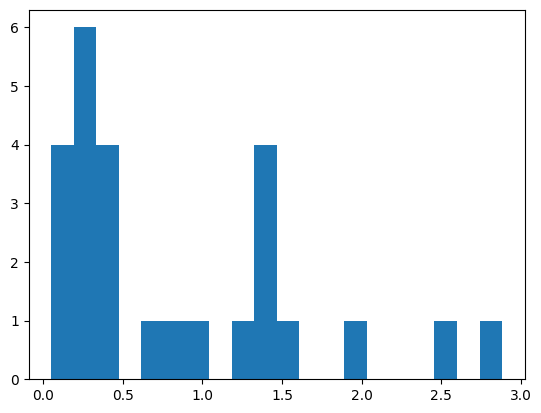

In [33]:
import matplotlib.pyplot as plt
plt.hist(Norms, bins = 20)
plt.show()

In [34]:
len([norm for norm in Norms if norm >=1 ] )

10

In [ ]:
#Make average capitalization vector
mean_distinct_lower_upper_vector =  torch.zeros(Z_dim).cuda()
for index in Upper_Lower_distinct_indexes:
    mean_distinct_lower_upper_vector = torch.add( mean_distinct_lower_upper_vector, lower_to_upper_dict[index])

print(mean_distinct_lower_upper_vector)
mean_distinct_upper_lower_vector = mean_distinct_lower_upper_vector/len(Upper_Lower_distinct_indexes)
print(mean_distinct_upper_lower_vector)

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0

In [344]:
print(1e-1)

0.1


In [298]:
#Generate dict of the mean number
Number_means = {}

for offset in range(10):
    num_indexes = labels_to_indexes[offset]
    num_mean = mean_latent_space_vector(num_indexes)
    Number_means[offset] = num_mean

    print(offset)
print(Number_means)

/tmp/ipykernel_66026/2705388341.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


0
1
2
3
4
5
6
7
8
9
{0: tensor([-0.0486,  1.7586, -0.3592,  0.3226], device='cuda:0',
       grad_fn=<DivBackward0>), 1: tensor([-1.3171, -1.4150, -0.3829, -0.1228], device='cuda:0',
       grad_fn=<DivBackward0>), 2: tensor([ 0.9367,  0.3439,  0.6909, -0.5600], device='cuda:0',
       grad_fn=<DivBackward0>), 3: tensor([-0.5568,  0.3207,  1.0250,  1.5168], device='cuda:0',
       grad_fn=<DivBackward0>), 4: tensor([ 0.0646, -0.7411,  0.1578, -0.2515], device='cuda:0',
       grad_fn=<DivBackward0>), 5: tensor([ 0.8945,  0.4823, -0.7192,  1.3620], device='cuda:0',
       grad_fn=<DivBackward0>), 6: tensor([-1.5097,  0.7385,  0.9170, -0.5531], device='cuda:0',
       grad_fn=<DivBackward0>), 7: tensor([ 1.1069, -1.3633,  1.1155,  0.3314], device='cuda:0',
       grad_fn=<DivBackward0>), 8: tensor([ 0.3109, -0.2116,  0.1776,  1.0464], device='cuda:0',
       grad_fn=<DivBackward0>), 9: tensor([ 0.1287, -0.9480,  0.8000,  0.4248], device='cuda:0',
       grad_fn=<DivBackward0>)}


In [401]:

def generate_mega_image_fractional_composite_mean_vector(fractional_value, file_name, include_numbers):
    Combined_View = torch.empty(0, 1, 28, 28).cuda()
    num_characters = 26
    if include_numbers:
        num_characters = 36
    for offset in range(num_characters):

        letter_index = 10 +offset
        lower_index  = 36 +offset 
        if include_numbers:
            letter_index = offset
            lower_index  = 26 + offset 


        A_indexes = labels_to_indexes[letter_index]
        test_image_A, test_target_A = test_dataset[A_indexes[0]]

        #Shape input into what the network wants
        z = torch.flatten(test_image_A)#.cuda(k
        z = torch.tensor(z)
        z = z.cuda()

        #Map through the model to the latent space and the whole way through
        if letter_index< 10:
            latent_sample = Number_means[letter_index]
        else:
            latent_sample = Lower_means[lower_index] 

        sample = vae.decoder(latent_sample)
        adjusted_latent = torch.add( latent_sample , ( fractional_value * mean_distinct_lower_upper_vector) )
        direct_sample = vae.decoder(adjusted_latent).cuda()

        comb_tensor = torch.cat( (z, sample, direct_sample) ).cuda()
        comb_view = comb_tensor.view(3, 1, 28, 28)

        comb_view = fix_tensor_for_image(comb_view)
        Combined_View = torch.cat((Combined_View, comb_view))

    save_image(Combined_View, './examples/average_figure/'+file_name+'_mega_image_mean_vector.png')

In [402]:
generate_mega_image_fractional_composite_mean_vector(0,'lower_case',True)
generate_mega_image_fractional_composite_mean_vector( 0.5 ,'middle',True)
generate_mega_image_fractional_composite_mean_vector(1,'back_to_upper_from_lower',True)

/tmp/ipykernel_66026/2532875063.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [347]:
print(mean_distinct_lower_upper_vector)
print(mean_distinct_upper_lower_vector)

tensor([[2.5287e+33, 5.5419e+00, 9.0254e-01, 2.2504e+00]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[2.1072e+32, 4.6183e-01, 7.5212e-02, 1.8753e-01]], device='cuda:0',
       grad_fn=<DivBackward0>)
